In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from reactionrnn import reactionrnn

import warnings; warnings.simplefilter('ignore')

C:\Users\kyle\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Clean Revenue and Budget

In [2]:
md = pd. read_csv('../data/movies_metadata.csv')
nsfw_data = pd.read_csv('../data/nsfw_score.csv')
credits = pd.read_csv('../data/credits.csv')
keywords = pd.read_csv('../data/keywords.csv')
nsfw_data.columns = ['id', 'nsfw_score']
#Converting both fields to the same data type
md['id'] = md['id'].astype(str)
nsfw_data['id'] = nsfw_data['id'].astype(str)
credits['id'] = credits['id'].astype(str)
md = md.merge(nsfw_data, on='id', how='left')
md = md.merge(credits, on='id', how='left')

In [3]:
md = (md.drop(['budget'], axis=1)
         .join(md['budget'].apply(pd.to_numeric, errors='coerce')))

md = md[md['budget'].notnull()]

In [4]:
md = md.replace(0,'NaN')
md = md[md.budget.notnull()]
md = md[md.budget != 'NaN']
md.loc[:, 'budget'] = pd.to_numeric(md['budget'])
md = md[md['budget'] != 0]
md = md[md['revenue'].notnull()]
md = md[md['revenue'] != 'NaN']

# Clean Genres and Production Companies

In [5]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
md['production_companies'] = md['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Add Language Features as Integer

In [7]:
md["Eng"] = md["original_language"] == 'en'
md["Eng"] = md["Eng"].astype(int)

In [8]:
md.belongs_to_collection[md.belongs_to_collection.notnull()] = 1
md.belongs_to_collection[md.belongs_to_collection.isnull()] = 0

In [9]:
md = md.drop(['title', 'original_title', 'overview', 'tagline', 'original_title','original_language','poster_path','homepage','id','imdb_id','popularity','vote_count', 'adult', 'status', 'video', 'vote_average','spoken_languages'], axis=1);

In [10]:
diff_genres = set()
for x in md.genres:
    for y in x:
        diff_genres.add(y)

In [11]:
for genre in diff_genres:
    md['is_' + str(genre)] = md['genres'].apply(lambda x: 1 if genre in x else 0)
md = md.drop('genres', axis=1)

In [12]:
md['production_countries'] = md['production_countries'].apply(lambda x: len(x))
md['production_companies'] = md['production_companies'].apply(lambda x: len(x))

In [13]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [14]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [15]:
md['month'] = md['release_date'].apply(get_month)

In [16]:
for month in month_order:
    md['release_' + str(month)] = md['month'].apply(lambda x: 1 if month in x else 0)
md = md.drop(['release_date', 'month'], axis =1);

In [17]:
md['cast'] = md['cast'].apply(literal_eval)
md['crew'] = md['crew'].apply(literal_eval)
md['cast_size'] = md['cast'].apply(lambda x: len(x))
md['crew_size'] = md['crew'].apply(lambda x: len(x))
md = md.drop(['cast','crew'], axis = 1)

In [18]:
#Adding profit column
md['profit'] = md['revenue'] >= md['budget']
md.loc[:, 'profit'] = md['profit'].astype(int)
md = md.drop(['budget', 'revenue'], axis=1)

In [23]:
md = md[md['runtime'] != 'NaN']
md = md[md['runtime'].notnull()]

In [24]:
md["belongs_to_collection"] = md["belongs_to_collection"].astype(int)
md["runtime"] = md["runtime"].astype(int)

In [25]:
X = md.loc[:, 'belongs_to_collection':'crew_size']

In [26]:
y = md['profit']

In [29]:
param_test = {
 'min_child_weight':[3,4,5,6,7]}

ind_params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic','nthread':16, 'max_depth' :5,
             'learning_rate':0.1, 'subsample':0.5, 'min_child_weight':3,
             'gamma':0}

def doGridCV(X,y):
    opt_xgb = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                param_test, 
                                scoring = 'accuracy', cv = 3, n_jobs= -1)
    opt_xgb.fit(X, y)
    print(opt_xgb.best_params_, opt_xgb.best_score_)


0.703566121842


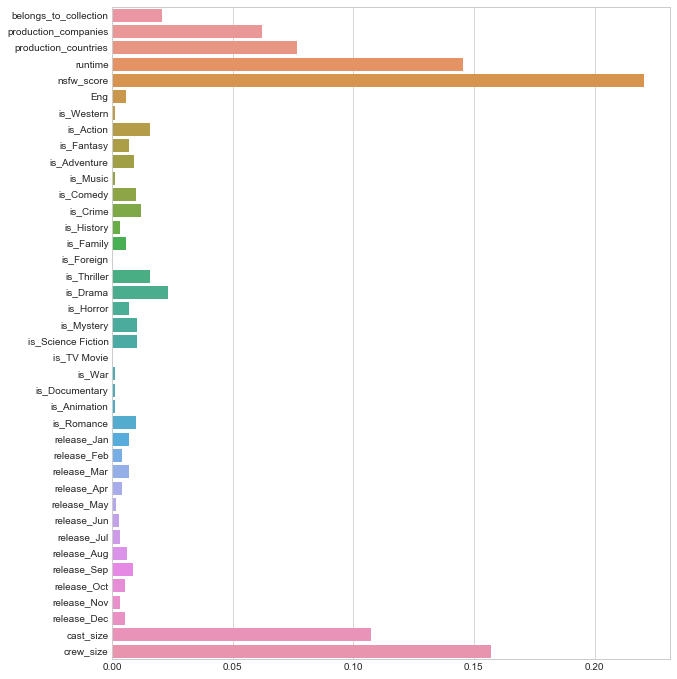

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=0)
model = xgb.XGBClassifier(**ind_params)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=model.feature_importances_, y=X.columns)